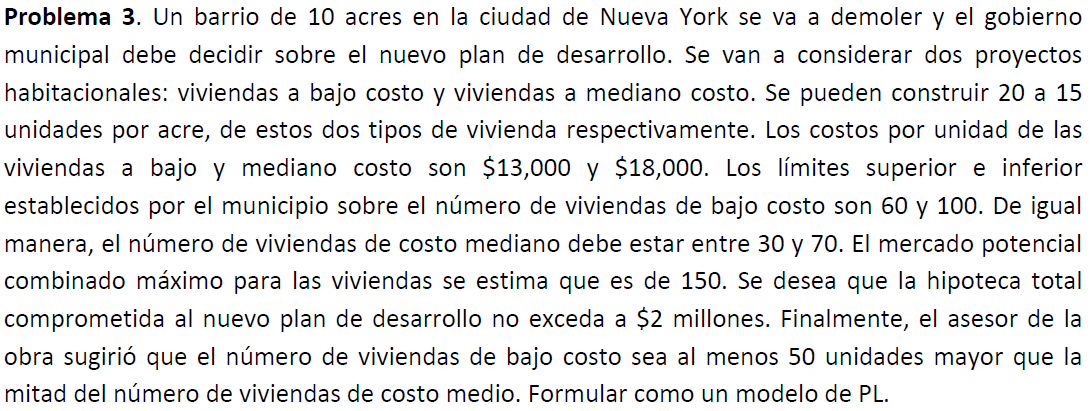

## Sets
I es el conjunto de tipo de viviendas (i = 1 son viviendas a bajo costo, i = 2 son viviendas a mediano costo)

In [43]:
import pyomo.environ as pe
import pyomo.opt as po

In [44]:
model = pe.ConcreteModel()

In [45]:
I = set(range(1,3))

In [46]:
model.I = pe.Set(initialize = I)

    (type: set).  This WILL potentially lead to nondeterministic behavior in
    Pyomo


## Parameters
LIi es el número de viviendas del tipo i mínimas requeridas (viviendas)\
LSi es el número de viviendas del tipo i máximas permitidas (viviendas)\
Ci es el costo unitario del tipo de vivienda i (dolar/vivienda)\
VAi es el número de viviendas del tipo i que se pueden construir por acre (viviendas/acre)\
A es la cantidad de acres que hay en el barrio de la ciudad de Nueva York (Acres)\
P es el presupuesto comprometido al nuevo plan de desarrollo (dolar)\
Max es el número potencial combinado máximo de viviendas (viviendas)

In [47]:
LI = {1: 60, 2: 30}
LS = {1: 100, 2: 70}
C = {1: 13000, 2: 18000}
VA = {1: 20, 2: 15}
A = 10
P = 2000000
Max = 150

In [48]:
model.LI = pe.Param(model.I, initialize = LI) #Viviendas mínimas requeridas
model.LS = pe.Param(model.I, initialize = LS) #Viviendas máximas permitidas
model.C = pe.Param(model.I, initialize = C) #Costo unitario
model.VA = pe.Param(model.I, initialize = VA) #Viviendas por acre
model.A = pe.Param(initialize = A) #Acres disponibles
model.P = pe.Param(initialize = P) #Presupuesto
model.Max = pe.Param(initialize = Max) #Máximo de viviendas

## Variables
xi es el número de viviendas del tipo i

In [49]:
model.x = pe.Var(model.I, domain = pe.NonNegativeReals)

## Objective

In [50]:
Z = sum(model.x[i] for i in model.I)
model.objective = pe.Objective(sense = pe.maximize, expr = Z)
model.objective.pprint()

objective : Size=1, Index=None, Active=True
    Key  : Active : Sense    : Expression
    None :   True : maximize : x[1] + x[2]


## Constraints

In [51]:
lhs = sum(model.x[i] for i in model.I)
rhs = model.Max
model.max_viviendas = pe.Constraint(expr = (lhs <= rhs))
model.max_viviendas.pprint()

max_viviendas : Size=1, Index=None, Active=True
    Key  : Lower : Body        : Upper : Active
    None :  -Inf : x[1] + x[2] : 150.0 :   True


In [52]:
cost_lhs = sum(model.C[i] * model.x[i] for i in model.I)
cost_rhs = model.P
model.budget = pe.Constraint(expr = (cost_lhs <= cost_rhs))
model.budget.pprint()

budget : Size=1, Index=None, Active=True
    Key  : Lower : Body                    : Upper     : Active
    None :  -Inf : 13000*x[1] + 18000*x[2] : 2000000.0 :   True


In [53]:
Acres_lhs = sum(model.x[i] / model.VA[i]  for i in model.I)
Acres_rhs = model.A
model.Acres = pe.Constraint(expr = (Acres_lhs <= Acres_rhs))
model.Acres.pprint()

Acres : Size=1, Index=None, Active=True
    Key  : Lower : Body                                 : Upper : Active
    None :  -Inf : 0.05*x[1] + 0.06666666666666667*x[2] :  10.0 :   True


In [54]:
model.sup = pe.ConstraintList()
for i in model.I:
    LS_lhs = model.x[i]
    LS_rhs = model.LS[i]
    model.sup.add(LS_lhs <= LS_rhs)
model.sup.pprint()

sup : Size=2, Index=sup_index, Active=True
    Key : Lower : Body : Upper : Active
      1 :  -Inf : x[1] : 100.0 :   True
      2 :  -Inf : x[2] :  70.0 :   True


In [55]:
model.lim = pe.ConstraintList()
for i in model.I:
    LI_lhs = model.x[i]
    LI_rhs = model.LI[i]
    model.lim.add(LI_lhs >= LI_rhs)
model.lim.pprint()

lim : Size=2, Index=lim_index, Active=True
    Key : Lower : Body : Upper : Active
      1 :  60.0 : x[1] :  +Inf :   True
      2 :  30.0 : x[2] :  +Inf :   True


In [56]:
additional_lhs = model.x[2]/2 + 50
additional_rhs = model.x[1]
model.additional = pe.Constraint(expr = (additional_lhs <= additional_rhs))
model.additional.pprint()

additional : Size=1, Index=None, Active=True
    Key  : Lower : Body                 : Upper : Active
    None :  -Inf : 0.5*x[2] + 50 - x[1] :   0.0 :   True


## Solver

In [57]:
solver = po.SolverFactory('glpk')
results = solver.solve(model, tee = True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpqzymay48.glpk.raw --wglp
 C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp5y25hfbd.glpk.glp --cpxlp C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpv5_sny9y.pyomo.lp
Reading problem data from 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmpv5_sny9y.pyomo.lp'...
9 rows, 3 columns, 13 non-zeros
52 lines were read
Writing problem data to 'C:\Users\JRODRI~1.VIL\AppData\Local\Temp\tmp5y25hfbd.glpk.glp'...
39 lines were written
GLPK Simplex Optimizer 5.0
9 rows, 3 columns, 13 non-zeros
Preprocessing...
3 rows, 2 columns, 6 non-zeros
Scaling...
 A: min|aij| =  5.000e-01  max|aij| =  1.800e+04  ratio =  3.600e+04
GM: min|aij| =  7.752e-01  max|aij| =  1.290e+00  ratio =  1.664e+00
EQ: min|aij| =  6.009e-01  max|aij| =  1.000e+00  ratio =  1.664e+00
Constructing initial basis...
Size of triangular part is 3
      0: obj =   9.000000000e+01 inf =   5.481e+00 (1)
      1: obj =   9

In [58]:
for i in model.I:
    print(pe.value(model.x[i]))
print(pe.value(model.objective))

100.0
38.8888888888889
138.8888888888889
